In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])
# plt.style.use(['seaborn-notebook'])

In [3]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

from utils import spaths
from utils import dmaps
import sf_nets.models as models
import sf_nets.datasets as datasets
from sf_nets.metrics import fast_ortho
from utils.mpl_utils import coord_grid

# Dataset

In [4]:
name_ds = 'Quad10'

In [5]:
dataset = getattr(datasets, name_ds)
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

## Path

In [6]:
times, path = torch.load(data_path / 'raw' / 'path.pt')
len(path)

12002

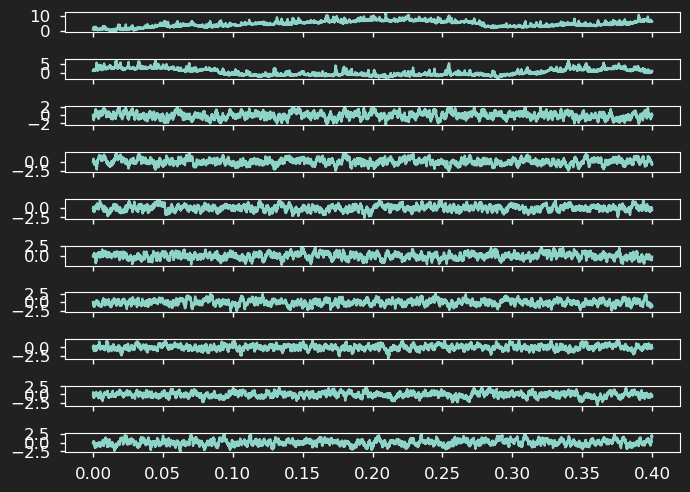

In [7]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [8]:
colors = ['#8dd3c7', '#feffb3', '#fa8174']
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

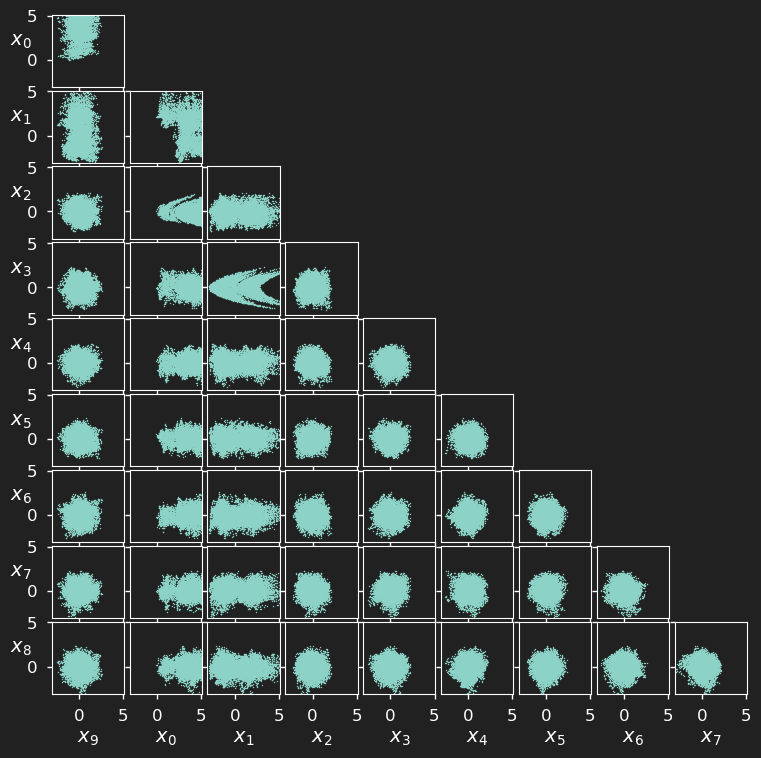

In [9]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, path, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

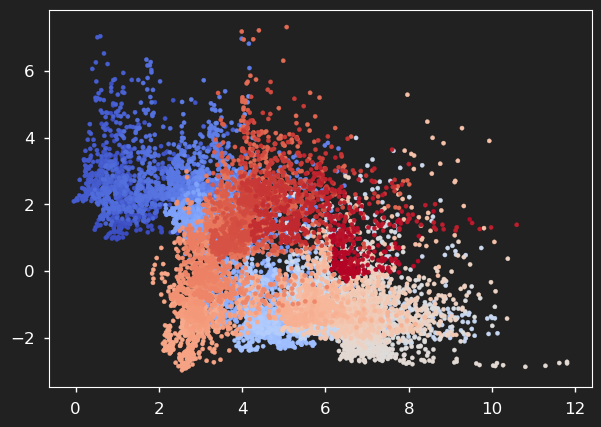

In [10]:
plt.scatter(*path.T[:2], c=times);

# Training dataset

In [11]:
train_ds = dataset(root / 'data')
train_data = train_ds.data.numpy()

In [12]:
test_ds = dataset(root / 'data', train=False)

In [13]:
np.any(train_ds == np.nan)

False

In [14]:
len(train_ds.slow_proj)

2010

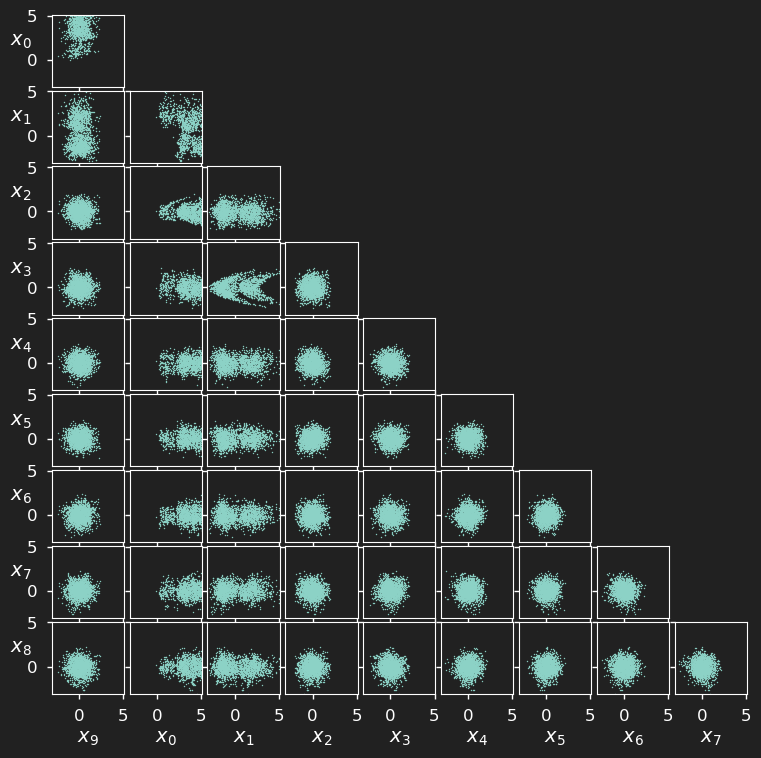

In [15]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, train_data, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

## Timescale separation

In [16]:
train_evals, _ = torch.symeig(train_ds.precs)

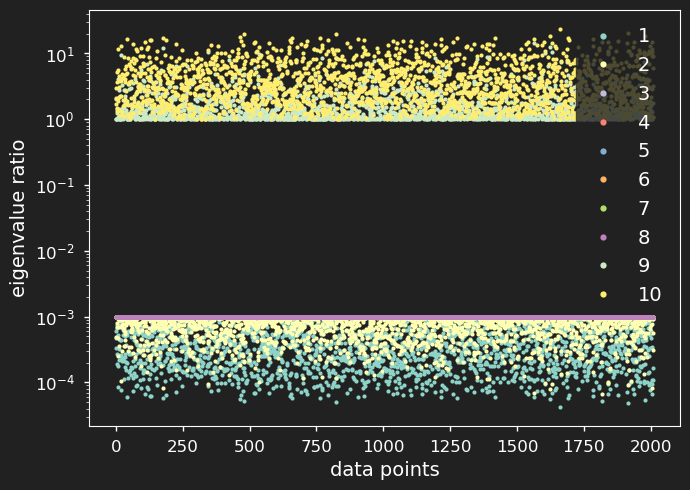

In [17]:
fig, ax = plt.subplots()
for n, e_val in enumerate(train_evals.T):
    ax.plot(e_val, 'o', label=f"{n+1}")
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalue ratio')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Projection

In [18]:
slow_proj = train_ds.slow_proj
slow_proj.size()

torch.Size([2010, 10])

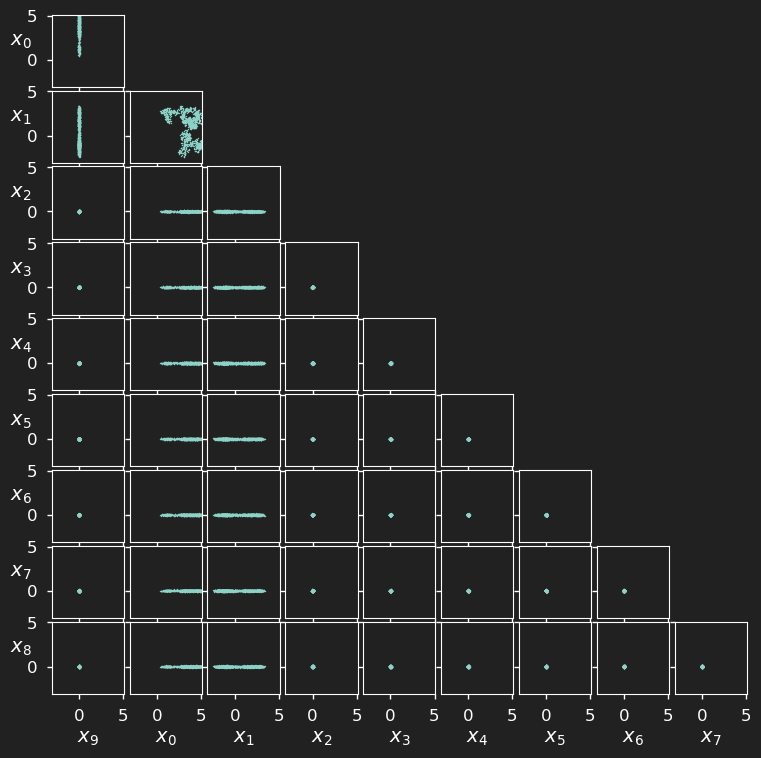

In [19]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, slow_proj, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

# Trained models

In [66]:
model_types = ['nib']

In [67]:
series_list = []
for file in os.listdir(model_path):
    fpath = Path(file)
    if fpath.suffix == '.pt' and any(mt in fpath.stem for mt in model_types):
        model_data = torch.load(model_path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
#         par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
        pruning = model_data['info']['config'].get('pruning')
        par_dict['sparsity'] = model_data['best']['sparsity'] if pruning else 0.0
        best_epoch_idx = model_data['best']['epoch']-1
        par_dict['best_epoch'] = best_epoch_idx
        par_dict['valid_loss'] = model_data['history']['valid_losses'][best_epoch_idx]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
avg = []
var = []
for model_id in models_df.model_id:
    model_data = torch.load(model_path / f'{model_id}.pt')
    model_arch = model_data['info']['architecture']
    model_args = model_data['info']['arguments']
    state_dict = model_data['best']['model_dict']
    
    model = getattr(models, model_arch)(**model_args)
    model.load_state_dict(state_dict)
    model.eval();
    
    avg_err = torch.mean(fast_ortho(model, test_ds)).numpy()
    var_err = torch.var(fast_ortho(model, test_ds)).numpy()
    
    avg.append(avg_err)
    var.append(var_err)
models_df['avg_err'] = avg
models_df['std_err'] = var

(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'avg_err': '{:.2}',
             'std_err': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,features,sparsity,best_epoch,valid_loss,avg_err,std_err
model_id,,,,,,,
mse_elu_0_nib,3000,"[10, 6, 2, 6, 10]",0%,1549,0.0081,0.28,0.0081
mse_elu_0_nib_r1,3000,"[10, 6, 2, 6, 10]",0%,2433,0.0036,0.14,0.0059
mse_elu_0_nib_r2,3000,"[10, 6, 2, 6, 10]",0%,1932,0.0064,0.35,0.0085
mse_elu_1_nib,3000,"[10, 6, 4, 2, 4, 6, 10]",0%,2121,0.0025,0.11,0.00061
mse_elu_1_nib_r1,3000,"[10, 6, 4, 2, 4, 6, 10]",0%,2800,0.0029,0.23,0.01
mse_elu_1_nib_r2,3000,"[10, 6, 4, 2, 4, 6, 10]",0%,2301,0.0031,0.18,0.0074
mse_elu_2_nib,3500,"[10, 10, 5, 2, 5, 10, 10]",0%,3214,0.0027,0.13,0.0066
mse_elu_2_nib_r1,3500,"[10, 10, 5, 2, 5, 10, 10]",0%,2712,0.0031,0.18,0.0089
mse_elu_2_nib_r2,3500,"[10, 10, 5, 2, 5, 10, 10]",0%,2838,0.0028,0.067,0.0013


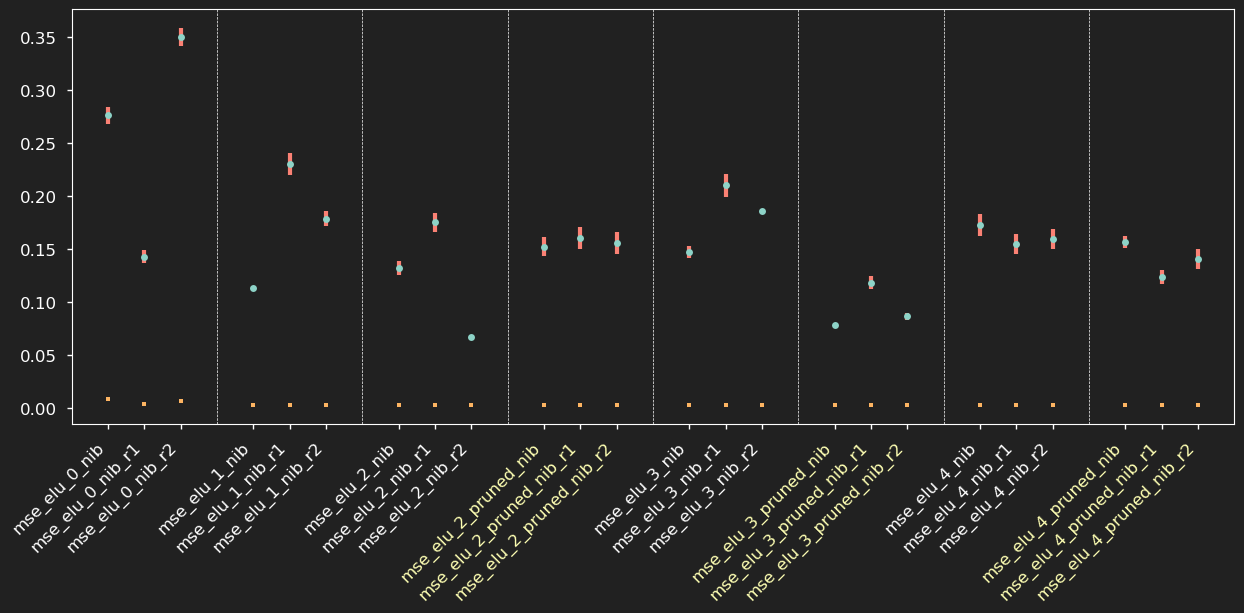

In [68]:
fig, ax = plt.subplots(figsize=(15,5.5))

n = 0
ticks = []
ticklabels = []
m_type = "mse_elu_0"
for _, (name, avg, std, loss) in models_df[['model_id', 'avg_err', 'std_err', 'valid_loss']].sort_values(by='model_id').iterrows():
#     print(n, name, avg, std)
    if m_type not in name:
        ax.axvline(n, ls='--', lw=.5)
        n += 1
        m_type = name
    ax.plot(n, avg, 'o', c='C0', ms=5)
    ax.plot(n, loss, 's', c='C5', ms=3)
    plt.vlines(n, avg-std, avg+std, lw=3, colors='C3')
    ticks.append(n)
    ticklabels.append(name)#.replace("_", "\_"))
    n += 1

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha="right")

ax.set_xlim([-1, n])

for n, tl in enumerate(ax.get_xticklabels()):
    if "pruned" in tl.get_text():
        tl.set_color('C1')

plt.show()
#     print(name, a, v)

## Loss

In [69]:
model_id = 'mse_elu_2_pruned_nib'

In [70]:
model_data = torch.load(model_path / f'{model_id}.pt')
print(f'{model_data.keys() = }')

model_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [71]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

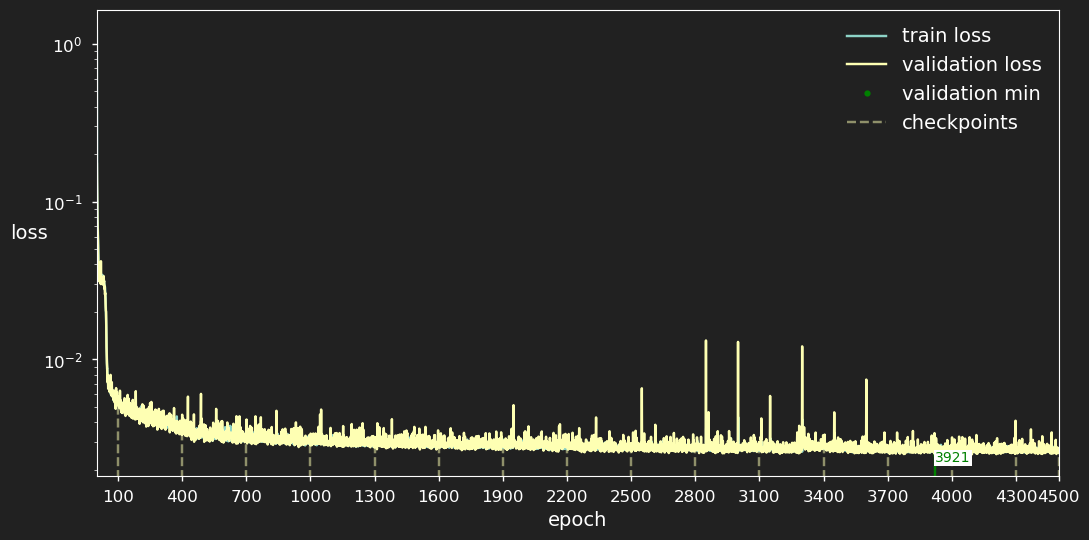

In [72]:
fig, ax = plt.subplots(figsize=(11,5.5))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .9*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids)
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
# fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Error in orthogonality

In [73]:
ortho_err_avg, ortho_err_std = zip(*[(d['ortho_error_avg'], d['ortho_error_std']) for d in model_data['history']['metrics']])
ortho_err_avg, ortho_err_std = np.array(ortho_err_avg), np.array(ortho_err_std)

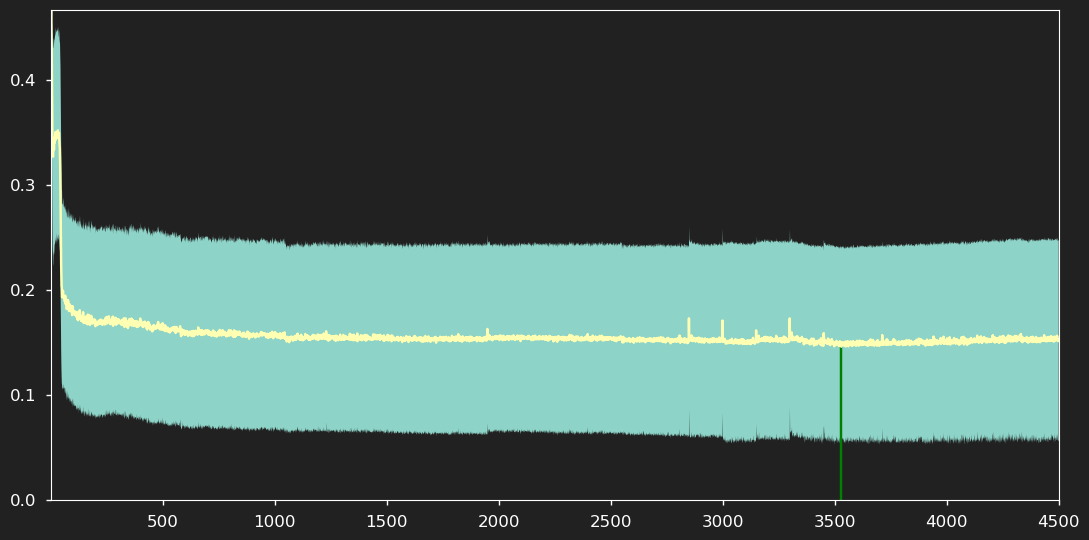

In [74]:
fig, ax = plt.subplots(figsize=(11,5.5))

ax.fill_between(epochs, ortho_err_avg - ortho_err_std, ortho_err_avg + ortho_err_std)
ax.plot(ortho_err_avg, c='C1')

min_error, min_error_epoch = np.amin(ortho_err_avg), ortho_err_avg.argmin()
plt.vlines(x=min_error_epoch, ymin=0, ymax=min_error, color='g')

ax.set_xlim([epochs[0], epochs[-1]+1])
ax.set_ylim(0, np.amax(ortho_err_avg))

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Load Model

In [28]:
model = getattr(models, model_data['info']['architecture'])(**model_data['info']['arguments'])
model

CoderNet(
  (encoder): Sequential(
    (layer1): Linear(in_features=10, out_features=8, bias=False)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=8, out_features=6, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=6, out_features=4, bias=True)
    (activation3): ELU(alpha=1.0)
    (layer4): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (layer1): Linear(in_features=2, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=6, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=6, out_features=8, bias=True)
    (activation3): ELU(alpha=1.0)
    (layer4): Linear(in_features=8, out_features=10, bias=True)
  )
  (loss_func): MSELoss()
)

In [29]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [39]:
check_epoch = 'best'

In [40]:
if check_epoch == 'best':
    state_dict = remove_mask(model_data['best']['model_dict'])
#     state_dict = model_data['best']['model_dict']
    check_epoch = best_epoch
else:
    check_dict = torch.load(model_path / f'{model_id}' / f'state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [41]:
model.load_state_dict(state_dict)

In [42]:
model.eval();

In [43]:
model.encoder.layer1.weight

Parameter containing:
tensor([[ 0.0000,  0.1053, -0.0000, -0.2756, -0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000],
        [ 0.2663,  0.3615,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.3984, -0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.8183, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.5751, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000, -0.0000],
        [ 0.4995,  0.0000,  0.0000, -0.0877, -0.0000, -0.0000, -0.0000, -0.0000,
          0.0000, -0.0000],
        [ 0.2631,  0.0000, -0.0000,  0.3349, -0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.7703, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
          0.0000, -0.0000]], requires_grad=True)

## Reconstruction visualization

In [44]:
with torch.no_grad():
    rec_train_data = model(train_ds.data)
slow_proj = train_ds.slow_proj
train_data_np = train_ds.data.detach().numpy()
rec_train_data_np = rec_train_data.numpy()
slow_proj_np = train_ds.slow_proj.detach().numpy()

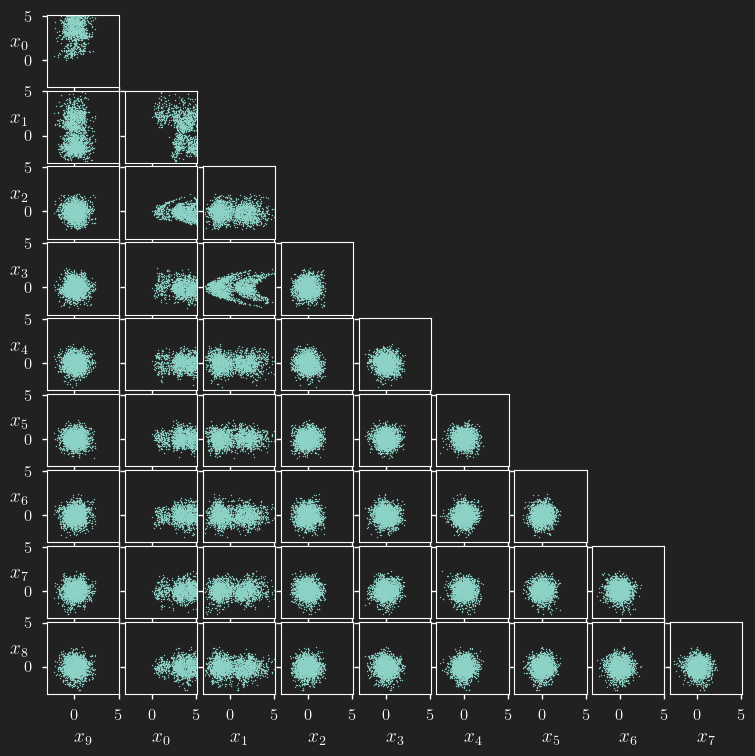

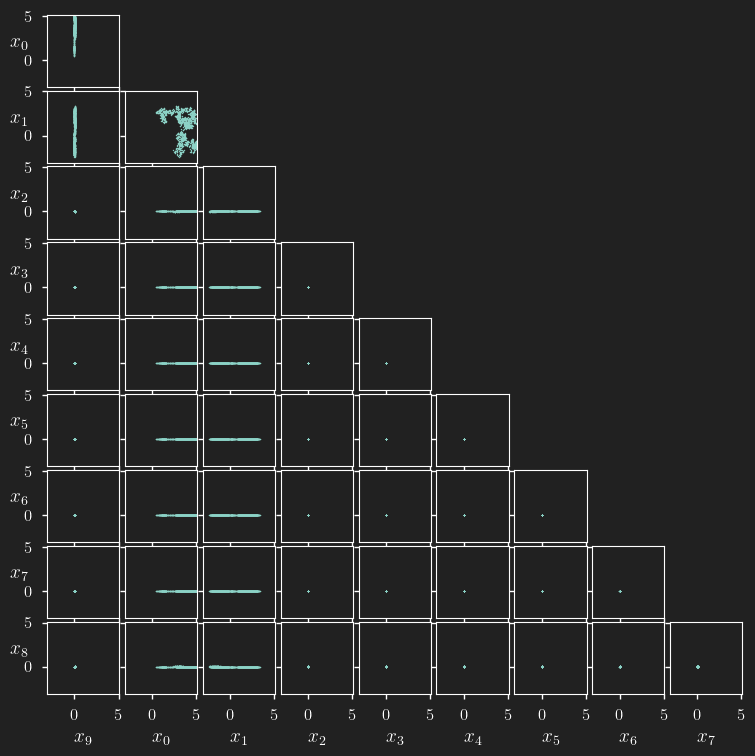

In [45]:
fig = plt.figure(figsize=(10,10))

coord_grid(fig, train_data_np, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

fig = plt.figure(figsize=(10,10))

coord_grid(fig, rec_train_data_np, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

## Encoder accuracy

In [112]:
test_ds = dataset(root / 'data', train=False)
len(test_ds)

991

In [113]:
test_data = test_ds.data
test_data_np = test_data.detach().numpy()
test_data_np.shape

(991, 10)

In [114]:
# plt.scatter(*test_data_np.T, s=3);

### Comparison to slow variable

In [115]:
dt = train_ds.dt
try:
    sde = train_ds.system.sde
except AttributeError:
    sde = train_ds.system
slow_map = train_ds.system.slow_map

In [116]:
slow_var = slow_map(test_data.detach().numpy().T)
lat_var = model.encoder(test_data).detach().numpy()

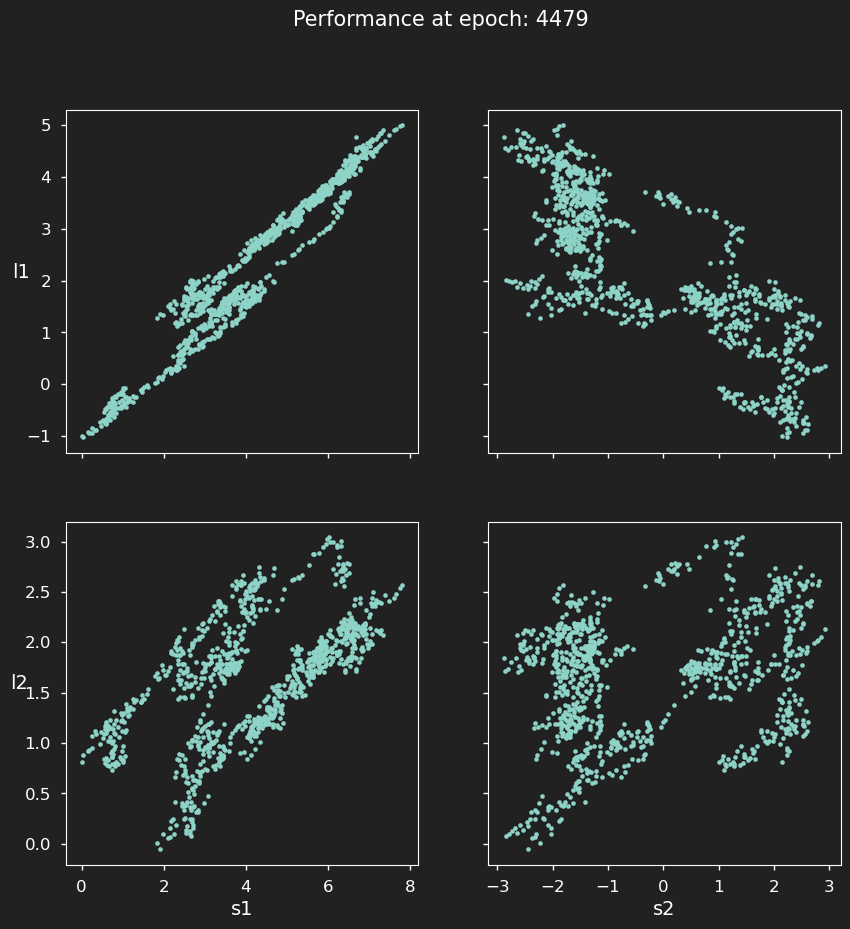

In [117]:
sdim = test_ds.system.sdim
fig, axs = plt.subplots(ncols=sdim, nrows=sdim, figsize=(5*sdim, 5*sdim),
                        sharey='row', sharex='col', squeeze=False)
for m, slow_coord in enumerate(slow_var):
    for n, lat_coord in enumerate(lat_var.T):
        axs[n,m].scatter(slow_coord, lat_coord)
        if n + 1 == sdim:
            axs[n,m].set_xlabel(f"s{m+1}")
        if m == 0:
            axs[n,m].set_ylabel(f"l{n+1}", rotation=0)
fig.suptitle(f'Performance at epoch: {check_epoch}', size=15)

plt.show()

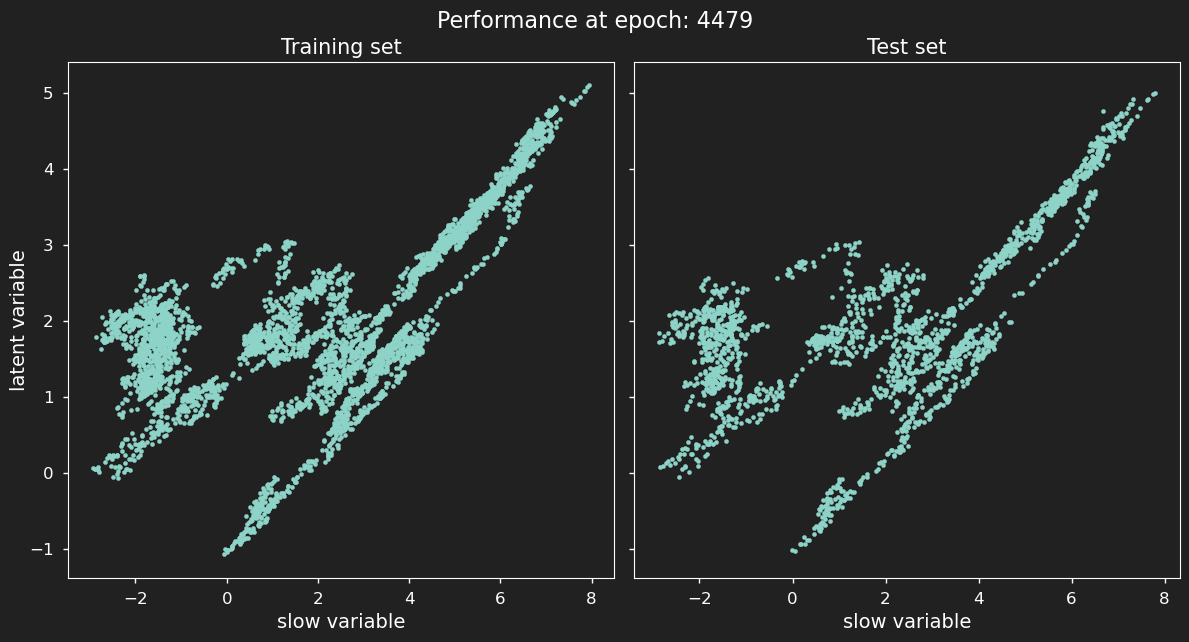

In [118]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6.5), sharey=True)

train_test_data = [train_ds.data, test_ds.data]
for ax, data, title in zip(axs, train_test_data, ['Training set', 'Test set']):
    slow_var = slow_map(data.detach().numpy().T)
    lat_var = model.encoder(data).detach().numpy()
    try:
        ax.scatter(slow_var, lat_var.T)
    except ValueError:
        print('Latent layer too large.')
        plt.close(fig)
    
    ax.set_title(f'{title}')
    ax.set_xlabel('slow variable')
axs[0].set_ylabel('latent variable', labelpad=0)

fig.tight_layout()

fig.suptitle(f'Performance at epoch: {check_epoch}', size=16)
fig.subplots_adjust(top=0.9)
# fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

### Two dimensional projection

In [299]:
print(lat_var.shape, slow_var.T.shape)

(991, 1) (991, 1)


In [300]:
ls_var = np.hstack([lat_var, slow_var.T])
ls_var.shape

(991, 2)

In [301]:
from sklearn.manifold import SpectralEmbedding

In [302]:
embedding = SpectralEmbedding(n_components=2)

In [303]:
X = embedding.fit_transform(ls_var)
X.shape

(991, 2)

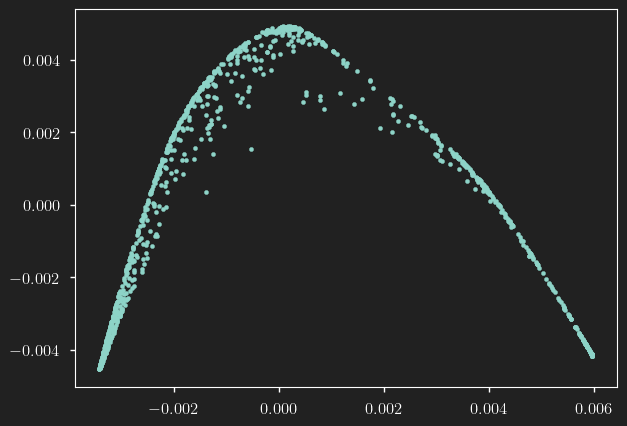

In [304]:
plt.scatter(*X.T);

### Relative variance of the image of short fibers

In [305]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

sde = train_ds.system

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [306]:
eps = train_ds.eps
dt = train_ds.burst_dt / 5 

In [307]:
fibs = em.solve(sde, test_data[::30], (0, 0.5*eps), dt).p
fibs = torch.from_numpy(fibs).float()
fibs.shape

torch.Size([34, 152, 4])

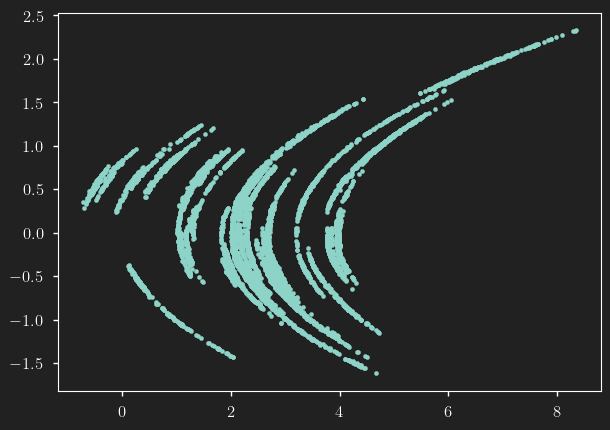

In [308]:
plt.scatter(*fibs.T[[0,1]]);

In [309]:
sfibs = slow_map(fibs.T).T
sfibs.shape

torch.Size([34, 152, 1])

In [310]:
var_sfibs = torch.mean(torch.var(sfibs, axis=1))
var_sfibs

tensor(0.0009)

In [311]:
with torch.no_grad():
    vfibs =  model.encoder(fibs)
vfibs.size()

torch.Size([34, 152, 1])

In [245]:
var_vfibs = torch.var(vfibs, axis=1)
var_vfibs.size()

torch.Size([34, 1])

In [246]:
simg = slow_map(test_data.T).T
simg.shape

torch.Size([991, 1])

In [247]:
with torch.no_grad():
    vimg =  model.encoder(test_data)
var_vimg = torch.var(simg, axis=0)
var_vimg.size()

torch.Size([1])

In [248]:
torch.mean(var_sfibs) / torch.mean(var_vimg)

tensor(0.0006)

In [249]:
torch.mean(var_vfibs) / torch.mean(torch.var(vimg, axis=0))

tensor(0.0543)

### Orthogonality

In [250]:
ndim = test_ds.system.ndim
sdim = test_ds.system.sdim
fdim = ndim - sdim

In [251]:
test_data = test_ds.data
test_data.size()

torch.Size([991, 4])

In [252]:
test_precs = test_ds.precs
test_precs.size()

torch.Size([991, 4, 4])

In [253]:
test_evals, test_evecs = torch.symeig(test_precs, eigenvectors=True)
test_evecs.size()

torch.Size([991, 4, 4])

In [254]:
idx = 10
for e_val, e_vec in zip(test_evals[idx], test_evecs[idx].T):
    print(e_val, ':', e_vec)

tensor(0.0004) : tensor([-0.8038, -0.5949, -0.0000, -0.0000])
tensor(0.0010) : tensor([-0., -0., 1., 0.])
tensor(0.0010) : tensor([0., 0., 0., 1.])
tensor(2.8250) : tensor([-0.5949,  0.8038,  0.0000,  0.0000])


In [255]:
torch.linalg.norm(torch.matmul(test_evecs, torch.transpose(test_evecs, 1, 2)) - torch.eye(ndim))

tensor(3.7716e-06)

In [256]:
f_evecs = test_evecs[:, :, :fdim]
f_evecs.size()

torch.Size([991, 4, 3])

In [257]:
f_evecs_T = torch.transpose(f_evecs, 1,2)
fTf = torch.matmul(f_evecs_T, f_evecs)
diff = torch.linalg.norm(fTf - np.eye(fdim), dim=(1,2))
diff.size()

torch.Size([991])

In [258]:
torch.mean(diff)

tensor(5.9424e-08, dtype=torch.float64)

#### Slow map

In [259]:
def slow_map_der(x):
        Ds = sdim
        Df = ndim - Ds
        x1, x2 = x[:Ds], x[Ds:]

        seye = np.eye(Ds)[..., None] * np.ones_like(x1)
        feye = -np.eye(Ds)[..., None] * 2 * x2[:Ds]
        fzer = np.zeros( (Ds, Df-Ds, x2.shape[1]) )
#         print(seye.shape, feye.shape, fzer.shape)

        return np.concatenate( [seye, feye, fzer] , axis=1)

In [260]:
test_data_np = test_data.detach().numpy()

In [261]:
der = torch.from_numpy(slow_map_der(test_data_np.T).T).float()
der.size()

torch.Size([991, 4, 1])

In [262]:
der_norm = der / torch.linalg.norm(der, dim=1, keepdim=True)

In [263]:
der_norm[idx]

tensor([[ 0.5950],
        [-0.8037],
        [ 0.0000],
        [ 0.0000]])

In [264]:
B = torch.vstack([f_evecs.T, der_norm.T]).T
B.size()

torch.Size([991, 4, 4])

In [265]:
BT = torch.transpose(B, 1, 2)
BT.size()

torch.Size([991, 4, 4])

In [266]:
BBT = torch.matmul(BT, B)
BBT.size()

torch.Size([991, 4, 4])

In [267]:
diff = torch.linalg.norm(BBT - torch.eye(ndim), dim=(1,2))

In [268]:
torch.mean(diff)

tensor(0.0003)

#### From model

In [269]:
test_data.requires_grad_(True);
# test_data.grad.zero_()
# test_data.grad.size()

In [270]:
# g = torch.diag_embed(torch.ones(len(test_data), 2))
# g.size()

In [271]:
# g = torch.vstack((torch.ones(len(test_data)), torch.zeros(len(test_data)))).T
# g.size()

In [272]:
g = torch.eye(sdim).repeat(len(test_data),1,1).T

In [273]:
# g[0].size()

In [274]:
# g1 = torch.tensor([[1,0]]).repeat(len(test_data), 1)
# g2 = torch.tensor([[0,1]]).repeat(len(test_data), 1)

In [275]:
grads_norm = []
for gi in g:
    v = model.encoder(test_data)
    v.backward(gi.T)
    grad = test_data.grad.clone()
    grads_norm.append(grad / torch.linalg.norm(grad, dim=1, keepdim=True))
    test_data.grad.zero_();
grads_norm = torch.stack(grads_norm, dim=2)

In [276]:
grads_norm.size()

torch.Size([991, 4, 1])

In [277]:
# v = model.encoder(test_data)
# v.backward(g1)
# grad1 = test_data.grad.clone()
# test_data.grad.zero_();

In [278]:
# v = model.encoder(test_data)
# v.backward(g2)
# grad2 = test_data.grad.clone()
# test_data.grad.zero_();

In [182]:
# grad1_norm = grad1 / torch.linalg.norm(grad1, dim=1, keepdim=True)
# grad1_norm.size()

In [183]:
# grad2_norm = grad2 / torch.linalg.norm(grad2, dim=1, keepdim=True)
# grad2_norm.size()

In [184]:
# grads = torch.stack([grad1_norm, grad2_norm], dim=2)
# grads.size()

In [185]:
grads_norm[idx]

tensor([[-0.1127, -0.4207],
        [ 0.6836, -0.1022],
        [ 0.2368,  0.8957],
        [ 0.6812, -0.1018],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])

In [186]:
A = torch.vstack([f_evecs.T, grads_norm.T]).T
A.size()

torch.Size([991, 10, 10])

In [187]:
AT = torch.transpose(A, 1, 2)
AT.size()

torch.Size([991, 10, 10])

In [188]:
AAT = torch.matmul(AT, A)
AAT.size()

torch.Size([991, 10, 10])

In [189]:
(AAT - torch.eye(ndim)).size()

torch.Size([991, 10, 10])

In [190]:
diff = torch.linalg.norm(AAT - np.eye(ndim), dim=(1,2))

In [191]:
torch.mean(diff)

tensor(0.2647, dtype=torch.float64)

## Sparsity patterns

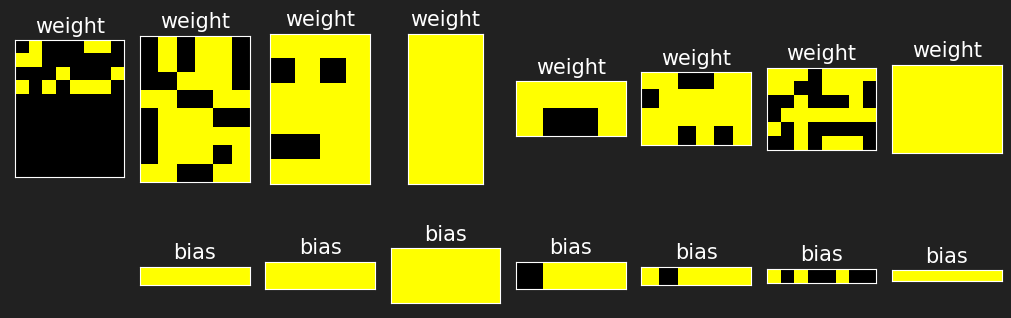

In [46]:
mpl.rcParams['text.usetex'] = False
if 'pruned' in model_id:
    par_dict = {}
    for coder_name, coder in model.named_children():
        for name, par in coder.named_parameters():
            par_np = par.detach().numpy()
            if par_np.ndim == 1:
                par_np = par_np[:, np.newaxis]
            layer_name, par_name = name.split('.')
            value = par_dict.setdefault(coder_name+layer_name, [])

            value.append((par_name, par_np.T))

    ncols = len(par_dict)
    import matplotlib.gridspec as gridspec
    fig = plt.figure(constrained_layout=True, figsize=(10, 3.5))

    gs = fig.add_gridspec(2, ncols)
    clim = (0, 1)
    # plt.setp(axs, xticks=[], yticks=[])
    for n, (layer_name, par_list) in enumerate(par_dict.items()):
        if len(par_list) == 1:
            ax = fig.add_subplot(gs[0,n])
            weights = par_list[0][1]
            Z = np.zeros(weights.shape + (3,))
            Z[weights != 0] = [1,1,0]
            im = ax.imshow(Z, clim=clim)
            ax.set_title(par_list[0][0])
        else:
    #         gap = -np.ones((2, par_list[0][1].shape[1]))
    #         mat = np.vstack((par_list[0][1], gap, par_list[1][1]))
            ax_w = fig.add_subplot(gs[0,n])
            weights = par_list[0][1]
            Z = np.zeros(weights.shape + (3,))
            Z[weights != 0] = [1,1,0]
            im = ax_w.imshow(Z)
            ax_w.set_title(par_list[0][0])
            ax_b = fig.add_subplot(gs[1,n], sharex=ax_w)
            biases = par_list[1][1]
            Z = np.zeros(biases.shape + (3,))
            Z[biases != 0] = [1,1,0]
            ax_b.imshow(Z)
            ax_b.set_title(par_list[1][0])

    all_axes = fig.get_axes()
    plt.setp(all_axes, xticks=[], yticks=[])
#     fig.colorbar(im)
    
#     fig.savefig(root / f"results/figs/{model_id}_wmats.pdf", dpi=300)
    plt.show(fig)
    plt.close(fig)
mpl.rcParams['text.usetex'] = True

### Plot of fast fibers (only for `sdim=1`)

In [312]:
def to_darray(*meshgrids):
    return np.stack(meshgrids).reshape(len(meshgrids), -1).T

def to_grid(darray, mesh_shape):
    if darray.ndim == 1:
        return darray.reshape(grid_size, -1)
    else:
#         rep = int( np.log(darray.shape[0]) / np.log(grid_size) )
        return darray.reshape(darray.shape[1], *mesh_shape )

In [313]:
slow_var = slow_map(test_data_np.T)
slow_var.shape

(1, 991)

In [314]:
lat_var = model.encoder(test_ds.data).detach().numpy().T
lat_var.shape

(1, 991)

In [315]:
ndim=dataset.system.ndim

In [316]:
def get_meshslice(coord1, coord2, grid_size, ndim):
    
    idx1, lim1 = coord1
    idx2, lim2 = coord2
    x = [0.0] * ndim
    x[idx1] = np.linspace(*lim1, grid_size)
    x[idx2] = np.linspace(*lim2, grid_size)
    
    return np.meshgrid(*x)

In [317]:
mesh_size = 100
x0 = np.linspace(+0.0, 4.0, mesh_size)
x1 = np.linspace(-2.0, 2.0, mesh_size)
x2, x3 = np.zeros((2, 1))
X = np.meshgrid(x0, x1, x2, x3)

In [318]:
coords = [
    (0, [0.0, 4.0]),
    (1, [-2.0, 2.0]),
    (2, [-2.0, 2.0]),
    (3, [-2.0, 2.0])
]

In [319]:
id1 = 0
id2 = 1
XX = get_meshslice(coords[id1], coords[id2], mesh_size, ndim)

In [320]:
mesh_shape = XX[0].shape
mesh_shape

(100, 100, 1, 1)

In [321]:
mesh_data = to_darray(*XX)
mesh_data.shape

(10000, 4)

In [322]:
v = slow_map(mesh_data.T).T
v.shape

(10000, 1)

In [323]:
mesh_data = torch.tensor(to_darray(*XX), dtype=torch.float)
with torch.no_grad():
    v = model.encoder(mesh_data)
v.size()

torch.Size([10000, 1])

In [324]:
VV = to_grid(v, mesh_shape)
VV.shape

torch.Size([1, 100, 100, 1, 1])

In [325]:
V = np.squeeze(VV)
X = np.squeeze(XX[id1])
Y = np.squeeze(XX[id2])

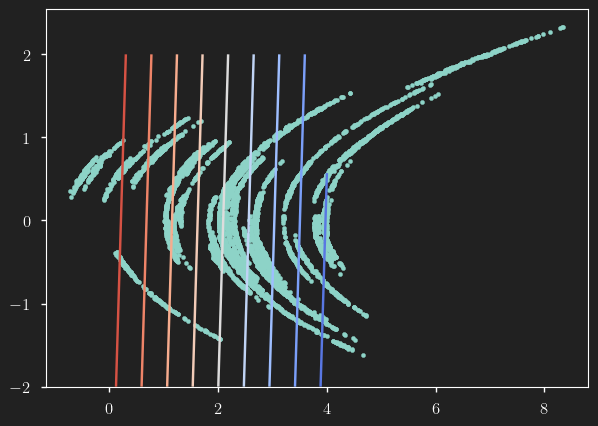

In [326]:
plt.contour(X, Y, V, levels=10);
plt.scatter(*fibs.T[:2])